In [1]:
import pandas as pd
import numpy as np

# Time

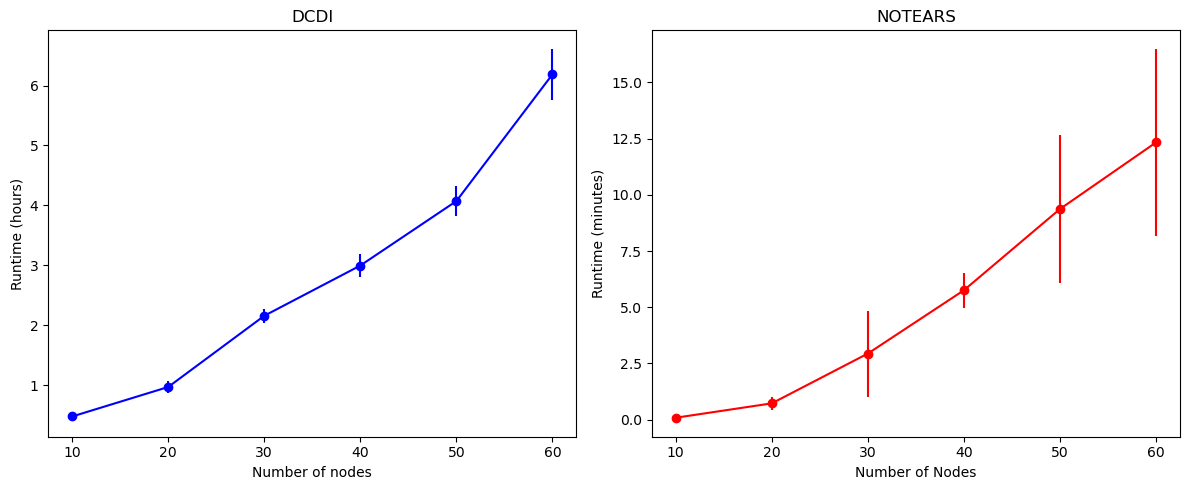

In [18]:
#!/usr/bin/env python3
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Path to your exp_scratch folder
root = "/home/ethan/IFT6168/exp_scratch"
csv_path = os.path.join(root, "notears_results.csv")

# 2) Load and aggregate DCDI timing (convert seconds → hours)
pattern = re.compile(r"^data_p(\d+)_\d+$")
times_by_N = {}
for entry in os.listdir(root):
    if "_copy" in entry or entry == os.path.basename(csv_path):
        continue
    m = pattern.match(entry)
    if not m:
        continue
    N = int(m.group(1))
    timing_file = os.path.join(root, entry, "train", "timing.pkl")
    if not os.path.isfile(timing_file):
        continue
    with open(timing_file, "rb") as f:
        t_sec = pickle.load(f)
    t_hr = t_sec / 3600.0  # convert to hours
    times_by_N.setdefault(N, []).append(t_hr)

node_sizes_d = sorted(times_by_N)
means_d     = [np.mean(times_by_N[N]) for N in node_sizes_d]
stds_d      = [np.std (times_by_N[N]) for N in node_sizes_d]

# 3) Load and aggregate NOTEARS results (convert seconds → minutes)
df = pd.read_csv(csv_path)
df['nodes']        = df['dataset'].str.extract(r'data_p(\d+)_').astype(int)
df['runtime_min']  = df['runtime'] / 60.0  # convert to minutes
grouped = df.groupby('nodes')['runtime_min'].agg(['mean','std']).reset_index()
node_sizes_n = grouped['nodes'].tolist()
means_n      = grouped['mean'].tolist()
stds_n       = grouped['std'].tolist()

# 4) Create a single figure with two side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Left: DCDI runtime (hours, blue)
axes[0].errorbar(node_sizes_d, means_d, yerr=stds_d,
                 marker='o', linestyle='-', color='blue')
axes[0].set_title("DCDI")
axes[0].set_xlabel("Number of nodes")
axes[0].set_ylabel("Runtime (hours)")

# Right: NOTEARS runtime (minutes, red)
axes[1].errorbar(node_sizes_n, means_n, yerr=stds_n,
                 marker='o', linestyle='-', color='red')
axes[1].set_title("NOTEARS")
axes[1].set_xlabel("Number of Nodes")
axes[1].set_ylabel("Runtime (minutes)")

plt.tight_layout()
plt.savefig("/home/ethan/IFT6168/exp_scratch/time_compare")


# NLL

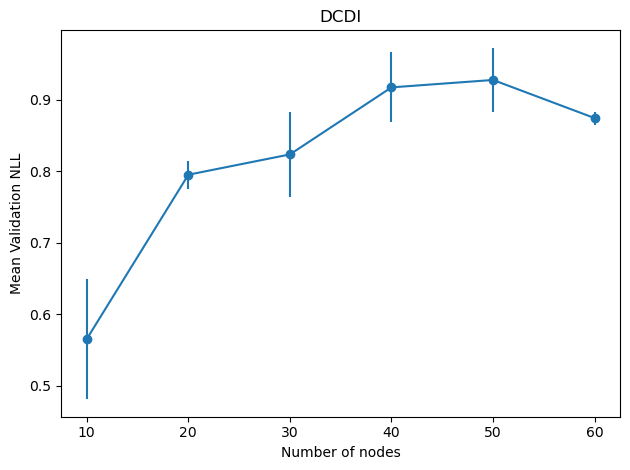

In [19]:
#!/usr/bin/env python3
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# Path to your exp_scratch folder
root = "/home/ethan/IFT6168/exp_scratch"

# Regex to capture N in directory name "data_p<N>_<replicate>"
pattern = re.compile(r"^data_p(\d+)_\d+$")

# Gather nll_val from each results.txt
nll_by_N = {}
for entry in os.listdir(root):
    if "_copy" in entry:
        continue
    m = pattern.match(entry)
    if not m:
        continue
    N = int(m.group(1))
    results_path = os.path.join(root, entry, "train", "results.txt")
    if not os.path.isfile(results_path):
        continue
    with open(results_path, "r") as f:
        content = f.read()
    match = re.search(r"nll_val\s*:\s*([0-9]*\.?[0-9]+)", content)
    if match:
        nll_val = float(match.group(1))
        nll_by_N.setdefault(N, []).append(nll_val)

# Compute mean and std for each N
node_sizes = sorted(nll_by_N)
means = [np.mean(nll_by_N[N]) for N in node_sizes]
stds  = [np.std(nll_by_N[N]) for N in node_sizes]

# Plot
plt.errorbar(node_sizes, means, yerr=stds, marker='o', linestyle='-')
plt.xlabel("Number of nodes")
plt.ylabel("Mean Validation NLL")
plt.title("DCDI")
plt.tight_layout()

plt.savefig("/home/ethan/IFT6168/exp_scratch/DCDI_NLL")

# Compare SHD

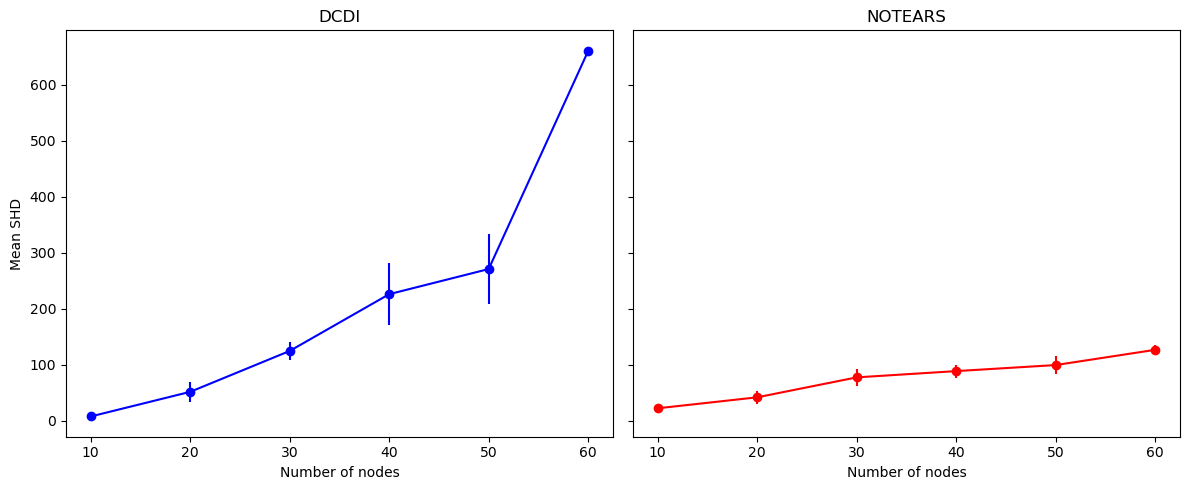

In [20]:
#!/usr/bin/env python3
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Path to your exp_scratch folder and NOTEARS CSV
root     = "/home/ethan/IFT6168/exp_scratch"
csv_path = os.path.join(root, "notears_results.csv")

# 2) Collect DCDI SHD from each train/results.txt
pattern = re.compile(r"^data_p(\d+)_\d+$")
shd_by_N = {}
for entry in os.listdir(root):
    if "_copy" in entry:
        continue
    m = pattern.match(entry)
    if not m:
        continue
    N = int(m.group(1))
    results_file = os.path.join(root, entry, "train", "results.txt")
    if not os.path.isfile(results_file):
        continue
    with open(results_file, "r") as f:
        text = f.read()
    match = re.search(r"shd\s*:\s*([0-9]+(?:\.[0-9]+)?)", text)
    if match:
        shd_val = float(match.group(1))
        shd_by_N.setdefault(N, []).append(shd_val)

node_sizes_d = sorted(shd_by_N)
means_d      = [np.mean(shd_by_N[N]) for N in node_sizes_d]
stds_d       = [np.std(shd_by_N[N])  for N in node_sizes_d]

# 3) Load NOTEARS SHD from CSV
df = pd.read_csv(csv_path)
df['nodes'] = df['dataset'].str.extract(r'data_p(\d+)_').astype(int)
grouped = df.groupby('nodes')['shd'].agg(['mean','std']).reset_index()
node_sizes_n = grouped['nodes'].tolist()
means_n      = grouped['mean'].tolist()
stds_n       = grouped['std'].tolist()

# 4) Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Left: DCDI
axes[0].errorbar(node_sizes_d, means_d, yerr=stds_d,
                 marker='o', linestyle='-', color='blue')
axes[0].set_title("DCDI")
axes[0].set_xlabel("Number of nodes")
axes[0].set_ylabel("Mean SHD")

# Right: NOTEARS
axes[1].errorbar(node_sizes_n, means_n, yerr=stds_n,
                 marker='o', linestyle='-', color='red')
axes[1].set_title("NOTEARS")
axes[1].set_xlabel("Number of nodes")

plt.tight_layout()
plt.savefig("/home/ethan/IFT6168/exp_scratch/shd_compare")
